# Obesity Risk EDA and Prediction

**Table of Contents**
1. Import Libraries
2. Read Data
3. EDA ( Exploratory Data Analysis )
4. Data Pre-processing
5. Model Comparison and Evaluation

## 1. Import Libraries

In [7]:
%%capture
!pip install catboost
!pip install pingouin

In [8]:
# Data manipulation
#====================
import os
import pandas as pd
import numpy as np
pd.set_option("display.max_columns", None)

# Data visualization
#====================
import matplotlib.pyplot as plt
import seaborn as sns

# Stats
#===================
import pingouin as pg

# Data preprocessing
#===================
import re
from sklearn.model_selection import train_test_split as tts
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler

# Models
#====================
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

# Metrics
#===================
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, classification_report

#Progress monitoring
#===================
from tqdm.auto import tqdm

# Warnings
#===================
import warnings
warnings.filterwarnings('ignore')

## 2. Read Data

In [9]:
path = '/kaggle/input/obesity-or-cvd-risk-classifyregressorcluster/ObesityDataSet.csv'
df = pd.read_csv(path)
df

,Gender,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS,NObeyesdad
0,Female,21.000000,1.620000,64.000000,yes,no,2.0,3.0,Sometimes,no,2.000000,no,0.000000,1.000000,no,Public_Transportation,Normal_Weight
1,Female,21.000000,1.520000,56.000000,yes,no,3.0,3.0,Sometimes,yes,3.000000,yes,3.000000,0.000000,Sometimes,Public_Transportation,Normal_Weight
2,Male,23.000000,1.800000,77.000000,yes,no,2.0,3.0,Sometimes,no,2.000000,no,2.000000,1.000000,Frequently,Public_Transportation,Normal_Weight
3,Male,27.000000,1.800000,87.000000,no,no,3.0,3.0,Sometimes,no,2.000000,no,2.000000,0.000000,Frequently,Walking,Overweight_Level_I
4,Male,22.000000,1.780000,89.800000,no,no,2.0,1.0,Sometimes,no,2.000000,no,0.000000,0.000000,Sometimes,Public_Transportation,Overweight_Level_II
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2106,Female,20.976842,1.710730,131.408528,yes,yes,3.0,3.0,Sometimes,no,1.728139,no,1.676269,0.906247,Sometimes,Public_Transportation,Obesity_Type_III
2107,Female,21.982942,1.748584,133.742943,yes,yes,3.0,3.0,Sometimes,no,2.005130,no,1.341390,0.599270,Sometimes,Public_Transportation,Obesity_Type_III
2108,Female,22.524036,1.752206,133.689352,yes,yes,3.0,3.0,Sometimes,no,2.054193,no,1.414209,0.646288,Sometimes,Public_Transportation,Obesity_Type_III
2109,Female,24.361936,1.739450,133.346641,yes,yes,3.0,3.0,Sometimes,no,2.852339,no,1.139107,0.586035,Sometimes,Public_Transportation,Obesity_Type_III


In [10]:
df.rename(columns={'NObeyesdad': 'Weight_Status'}, inplace=True)
target_column = 'Weight_Status'

## 3. EDA ( Exploratory Data Analysis )

In [11]:
print("#" * 50)
print(" " * 15, "Dataset Information")
print("#" * 50)
print("The Dataset has {} columns and {} rows.".format(df.shape[1], df.shape[0]))
print("The DataFrame has {} duplicated values and {} missing values.".format(df.duplicated().sum(), df.isnull().sum().sum()))
print(df.info())

##################################################
                Dataset Information
##################################################
The Dataset has 17 columns and 2111 rows.
The DataFrame has 24 duplicated values and 0 missing values.
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2111 entries, 0 to 2110
Data columns (total 17 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Gender                          2111 non-null   object 
 1   Age                             2111 non-null   float64
 2   Height                          2111 non-null   float64
 3   Weight                          2111 non-null   float64
 4   family_history_with_overweight  2111 non-null   object 
 5   FAVC                            2111 non-null   object 
 6   FCVC                            2111 non-null   float64
 7   NCP                             2111 non-null   float64
 8   CAEC                            2111 

In [12]:
df.drop_duplicates(inplace=True)

In [13]:
df['Age'] = df['Age'].astype(int)

In [14]:
# Select categorical columns
categorical_features = df.select_dtypes(include=['object', 'category'])

# Create a DataFrame from categorical columns with their unique values
cat_feature_info = pd.DataFrame(columns=['Feature', 'Unique_Values'])
for cat_feat in categorical_features:
    unique_values = df[cat_feat].unique()
    cat_feature_info = pd.concat([cat_feature_info, pd.DataFrame({'Feature': cat_feat, 'Unique_Values': [unique_values]})], ignore_index=True)

# Display
display(cat_feature_info)

,Feature,Unique_Values
0,Gender,"[Female, Male]"
1,family_history_with_overweight,"[yes, no]"
2,FAVC,"[no, yes]"
3,CAEC,"[Sometimes, Frequently, Always, no]"
4,SMOKE,"[no, yes]"
5,SCC,"[no, yes]"
6,CALC,"[no, Sometimes, Frequently, Always]"
7,MTRANS,"[Public_Transportation, Walking, Automobile, M..."
8,Weight_Status,"[Normal_Weight, Overweight_Level_I, Overweight..."


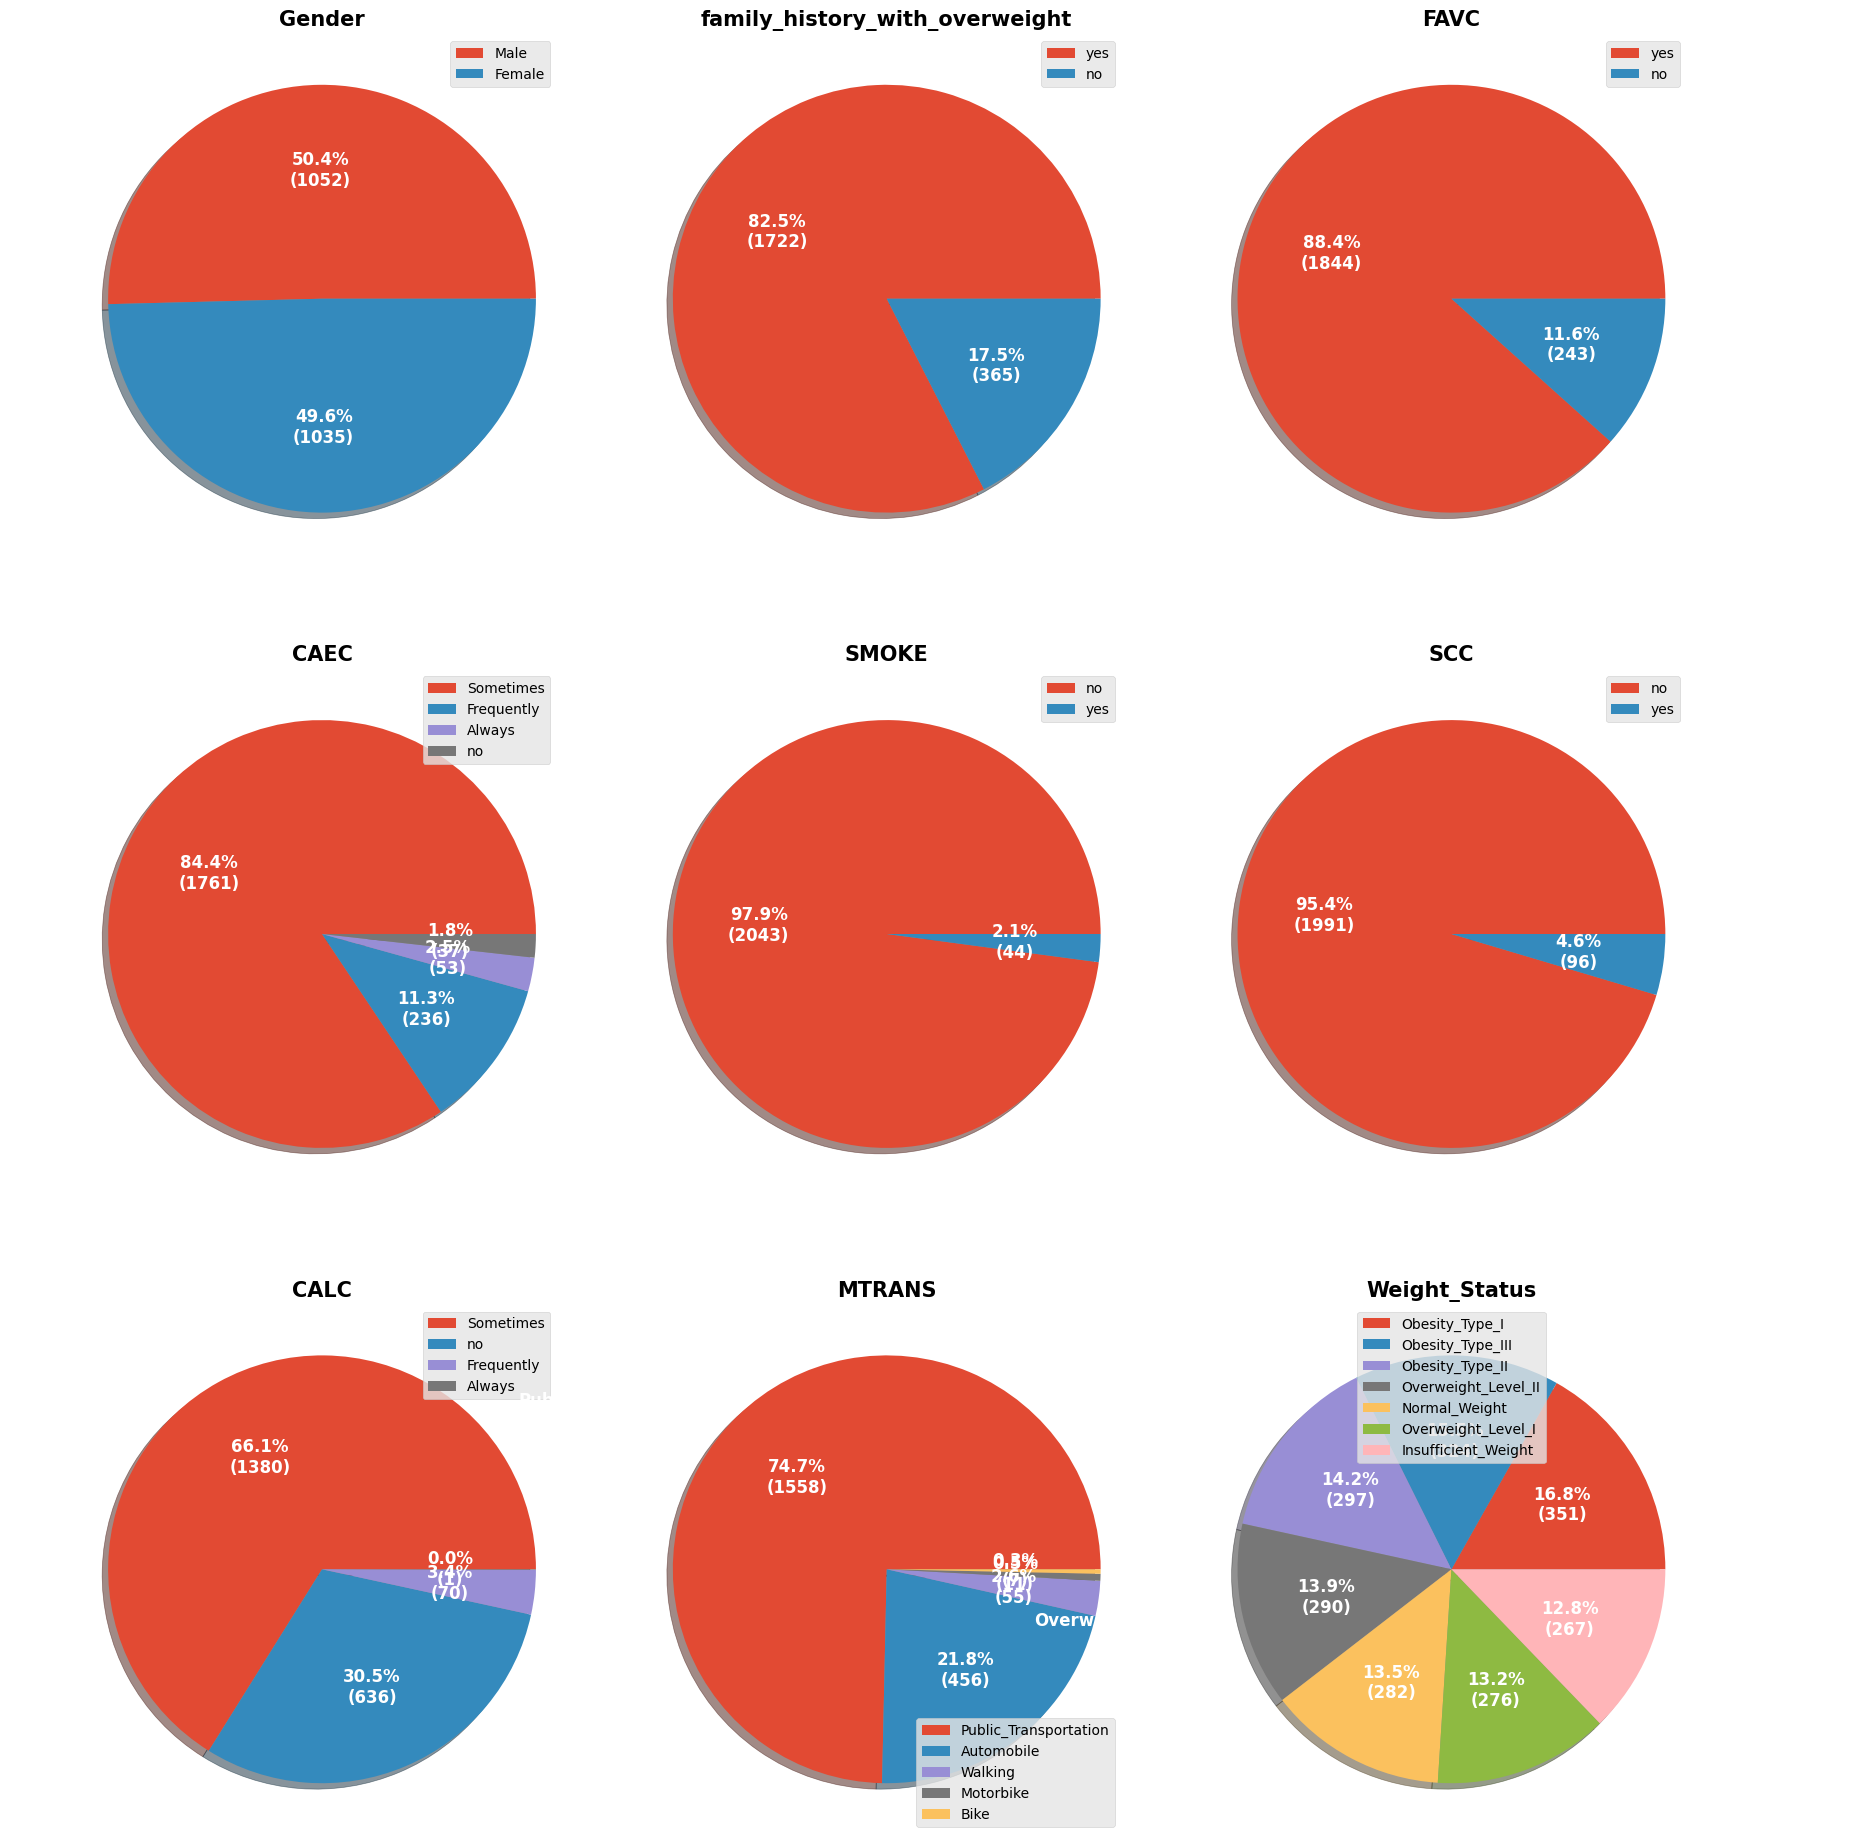

In [15]:
plt.style.use('ggplot')

def autopct_fun(abs_values):
    gen = iter(abs_values)
    return lambda pct: f"{pct:.1f}%\n({next(gen)})"
 
fig,ax = plt.subplots(nrows = 3, ncols = 3, figsize = (20,40))
ax = ax.flat

for i,cat_feat in enumerate(categorical_features):
    df_class = df[cat_feat].value_counts().to_frame() 
    labels = df_class.index 

    values = df_class.iloc[:,0].to_list()
    ax[i].pie(x = values, labels = labels, autopct=autopct_fun(values), shadow = True, textprops = {'color':'white', 'fontsize':12, 'fontweight':'bold'})
    ax[i].legend(labels, loc = 'best')
    ax[i].set_title(cat_feat, fontsize = 15, fontweight = "bold", color = "black")
    ax[i].axis('equal')

plt.subplots_adjust(left=0.1, right=0.9, top=0.5, bottom=0.05)


In [16]:
categorical_features = df.select_dtypes(include=['category', 'object']).columns

In [17]:
def analyze_categorical_dependency(df, target, p_value_threshold=0.05, power_threshold=0.7):
    # Store the results in an empty list
    results = []

    # Get the categorical columns of df
    #categorical_features = df.select_dtypes(include=['category', 'object']).columns

    # Perform chi-square test for each categorical feature
    for feature in categorical_features:
        # Compare with target value, but don't compare with itself
        if feature != target:
            # Apply chi-square independence test
            chi2_result = pg.chi2_independence(data=df, x=feature, y=target)
            stats = chi2_result[2]
            
            # Get p-value and power values
            p_value = stats['pval'].iloc[0]
            power = stats['power'].iloc[0]

            # Check for NaN
            p_value = 1 if pd.isnull(p_value) else p_value
            power = 0 if pd.isnull(power) else power

            # Check dependency and power status
            dependency = 'Yes' if p_value < p_value_threshold else 'No'
            reliable = 'Yes' if power > power_threshold else 'No'

            # Append the results
            results.append({
                'Feature': feature,
                'p-value': p_value,
                'power': power,
                'dependency': dependency,
                'reliable': reliable
            })

    # Return the results as a DataFrame
    return pd.DataFrame(results)

results_df = analyze_categorical_dependency(df, target_column)
results_df

,Feature,p-value,power,dependency,reliable
0,Gender,9.357968e-139,1.000000,Yes,Yes
1,family_history_with_overweight,3.524156e-130,1.000000,Yes,Yes
2,FAVC,4.089708e-47,1.000000,Yes,Yes
3,CAEC,6.301258e-142,1.000000,Yes,Yes
4,SMOKE,1.739791e-05,0.996033,Yes,Yes
5,SCC,3.338513e-25,1.000000,Yes,Yes
6,CALC,2.220940e-60,1.000000,Yes,Yes
7,MTRANS,3.331989e-47,0.999976,Yes,Yes


## 4. Data Pre-Processing

In [18]:
labels = df[target_column].unique()

# Sort labels alphabetically
labels.sort()

# Create a dictionary
label_dict = {label: i for i, label in enumerate(labels)}

print(label_dict)

{'Insufficient_Weight': 0, 'Normal_Weight': 1, 'Obesity_Type_I': 2, 'Obesity_Type_II': 3, 'Obesity_Type_III': 4, 'Overweight_Level_I': 5, 'Overweight_Level_II': 6}


In [19]:
df[target_column] = df[target_column].map(label_dict)

In [20]:
X = df.drop(target_column, axis = 1)
y = df[target_column]

SEED = 42

X_train, X_test, y_train, y_test = tts(X, 
                                       y, 
                                       test_size = 0.2, 
                                       random_state = SEED,
                                       stratify=y)

In [21]:
# Get the original labels for the training and test sets using reverse_label_dict
reverse_label_dict = {v: k for k, v in label_dict.items()}
y_train_named = y_train.map(reverse_label_dict)
y_test_named = y_test.map(reverse_label_dict)

# Count the label distributions for training and test sets
train_label_distribution = y_train_named.value_counts()
test_label_distribution = y_test_named.value_counts()

# Merge training and test label distributions into a single DataFrame
label_distribution = pd.concat([train_label_distribution, test_label_distribution], axis=1, keys=['Count (Training)', 'Count (Test)'])

# Show the label distributions for training and test sets
print("Label Distribution in Training and Test Sets:")
display(label_distribution)

Label Distribution in Training and Test Sets:


,Count (Training),Count (Test)
Weight_Status,,
Obesity_Type_I,281,70
Obesity_Type_III,259,65
Obesity_Type_II,237,60
Overweight_Level_II,232,58
Normal_Weight,225,57
Overweight_Level_I,221,55
Insufficient_Weight,214,53


In [22]:
categorical_features = df.select_dtypes(include=['object', 'category']).columns

preprocessor = ColumnTransformer([('ohe', OneHotEncoder(drop = 'first', 
                                                        sparse_output = False, 
                                                        handle_unknown = "ignore"), 
                                   categorical_features)], 
                                 remainder = 'passthrough', 
                                 verbose_feature_names_out = False).set_output(transform = 'pandas')

X_train_prep = preprocessor.fit_transform(X_train)
X_test_prep = preprocessor.transform(X_test)

In [ ]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_prep)
X_test_scaled = scaler.transform(X_test_prep)

## 5. Model Comparison and Evaluation

In [23]:
lr = LogisticRegression(random_state=SEED, multi_class='multinomial', max_iter=1000)
lr.fit(X_train_scaled, y_train)

y_pred_train = lr.predict(X_train_scaled)
y_pred_test = lr.predict(X_test_scaled)

print(f"Accuracy Train: {accuracy_score(y_train, y_pred_train):.4f}")
print(f"Accuracy Test: {accuracy_score(y_test, y_pred_test):.4f}")

Accuracy Train: 0.8999
Accuracy Test: 0.8923


In [24]:
# ML models
clf1 = RandomForestClassifier(random_state = SEED, n_jobs = -1)
clf2 = ExtraTreesClassifier(bootstrap = True, n_jobs = -1, random_state = SEED)
clf3 = XGBClassifier(random_state = SEED)
clf4 = LGBMClassifier(random_state = SEED, n_jobs = -1)
clf5 = CatBoostClassifier(random_state = SEED, verbose = 0)

models_list = [clf1, clf2, clf3, clf4, clf5]

In [25]:
# Training

accuracy_train = {}
accuracy_test = {}

for model in tqdm(models_list):
    name = type(model).__name__
    model.fit(X_train_prep, y_train)
    y_pred_train = model.predict(X_train_prep)
    y_pred_test = model.predict(X_test_prep)
    accuracy_train[name] = accuracy_score(y_train, y_pred_train)
    accuracy_test[name] = accuracy_score(y_test, y_pred_test)
    print(f'* {name} finished.')

  0%|          | 0/5 [00:00<?, ?it/s]

* RandomForestClassifier finished.
* ExtraTreesClassifier finished.
* XGBClassifier finished.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002793 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1844
[LightGBM] [Info] Number of data points in the train set: 1669, number of used features: 21
[LightGBM] [Info] Start training from score -2.054004
[LightGBM] [Info] Start training from score -2.003880
[LightGBM] [Info] Start training from score -1.781625
[LightGBM] [Info] Start training from score -1.951920
[LightGBM] [Info] Start training from score -1.863152
[LightGBM] [Info] Start training from score -2.021817
[LightGBM] [Info] Start training from score -1.973243
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No fu

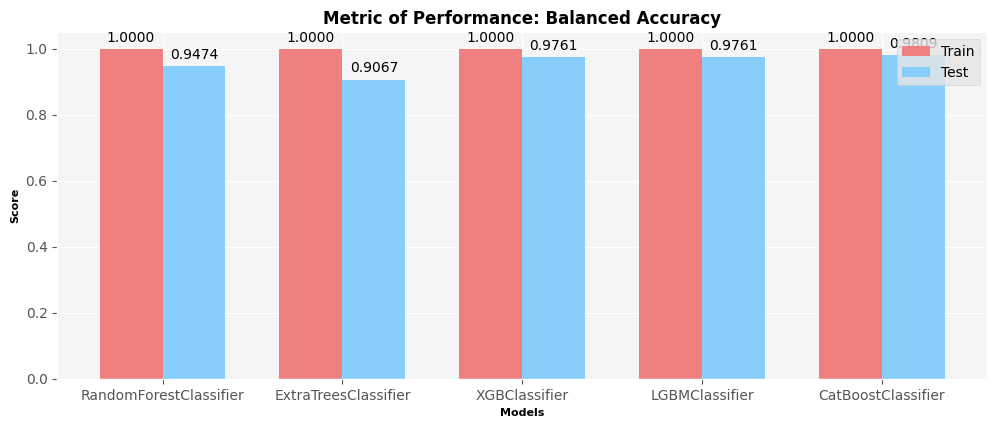

In [27]:
# Create DataFrame from dictionary for train and test metrics
metric_train = pd.DataFrame.from_dict(accuracy_train, orient='index')
metric_train = metric_train.rename(columns={0: 'Train'})
metric_test = pd.DataFrame.from_dict(accuracy_test, orient='index')
metric_test = metric_test.rename(columns={0: 'Test'})

# Create subplots
fig, ax = plt.subplots(figsize=(12, 4.5))

# Get labels, train and test values
labels = metric_train.index.to_list()
values_train = metric_train.iloc[:, 0].to_list()
values_test = metric_test.iloc[:, 0].to_list()
x = np.arange(len(labels))
width = 0.35

# Plot bars for train and test metrics
rects1 = ax.bar(x=x - width / 2, height=values_train, width=width, label='Train', color='lightcoral')
rects2 = ax.bar(x=x + width / 2, height=values_test, width=width, label='Test', color='lightskyblue')

# Function to label bars with their values
def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate(text=f'{height:.4f}',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),
                    textcoords="offset points",
                    ha="center",
                    va="bottom")

# Call autolabel function for train and test bars
autolabel(rects1)
autolabel(rects2)

# Add legend, title, and axis labels
ax.legend()
ax.set_title("Metric of Performance: Balanced Accuracy", fontsize=12, fontweight="bold", color="black")
ax.set_ylabel("Score", fontsize=8, fontweight="bold", color="black")
ax.set_xlabel("Models", fontsize=8, fontweight="bold", color="black")
ax.set_xticks(x)
ax.set_xticklabels(labels)

# Set background color of the plot
ax.set_facecolor('whitesmoke')

# Show the plot
plt.show()

In [28]:
# clf5(CatBoostClassifier) wins
# Predictions
y_pred_train_final = clf5.predict(X_train_prep)
y_pred_test_final = clf5.predict(X_test_prep)

In [29]:
print("##" * 30)
print(" " * 12, "Classification Report Train")
print("##" * 30)
print(classification_report(y_train, y_pred_train_final))
print("")

print("##" * 30)
print(" " * 12, "Classification Report Test")
print("##" * 30)
print(classification_report(y_test, y_pred_test_final))

############################################################
             Classification Report Train
############################################################
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       214
           1       1.00      1.00      1.00       225
           2       1.00      1.00      1.00       281
           3       1.00      1.00      1.00       237
           4       1.00      1.00      1.00       259
           5       1.00      1.00      1.00       221
           6       1.00      1.00      1.00       232

    accuracy                           1.00      1669
   macro avg       1.00      1.00      1.00      1669
weighted avg       1.00      1.00      1.00      1669


############################################################
             Classification Report Test
############################################################
              precision    recall  f1-score   support

           0       1.0

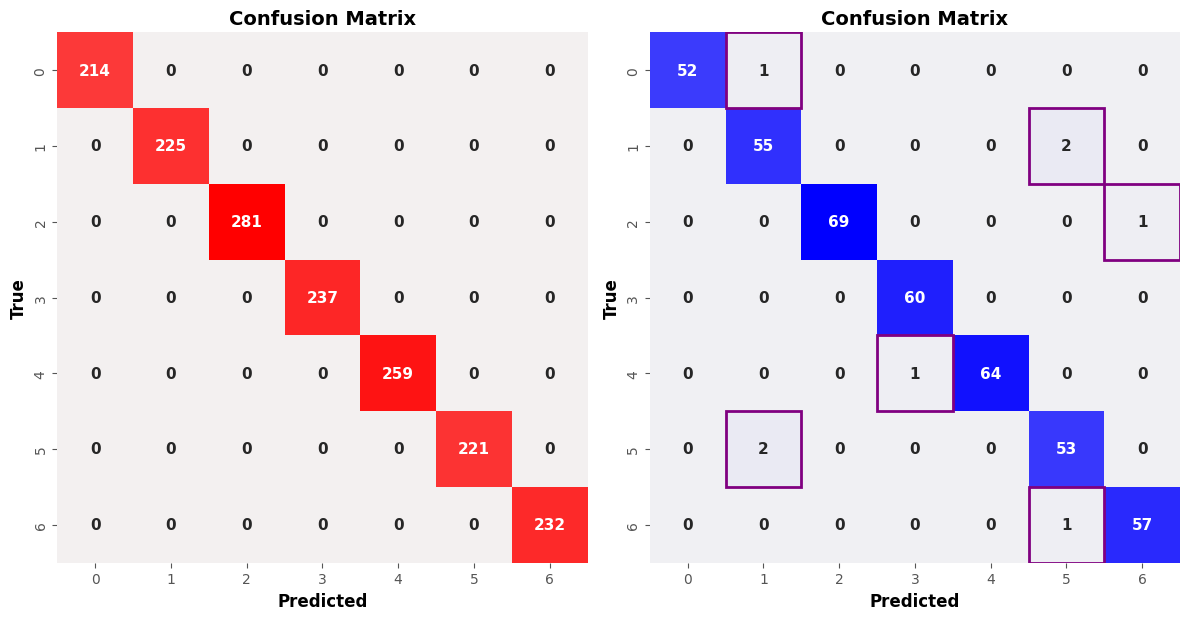

In [30]:
# Calculate the Confusion Matrices
cf_mx_train = confusion_matrix(y_train, y_pred_train_final)
cf_mx_test = confusion_matrix(y_test, y_pred_test_final)

# Define the color palettes
palette_train = sns.light_palette("red", as_cmap=True)
palette_test = sns.light_palette("blue", as_cmap=True)

# Create a 1x2 subplot
fig, axs = plt.subplots(1, 2, figsize=(12, 8))

# Create heatmaps for each subplot
sns.heatmap(cf_mx_train, cmap=palette_train, annot=True, annot_kws={'fontsize': 11, 'fontweight': 'bold'}, fmt='', cbar=False, square=True, ax=axs[0])
sns.heatmap(cf_mx_test, cmap=palette_test, annot=True, annot_kws={'fontsize': 11, 'fontweight': 'bold'}, fmt='', cbar=False, square=True, ax=axs[1])

# Check the values in non-diagonal squares and make them purple if different from zero
for ax, cf_mx in zip(axs, [cf_mx_train, cf_mx_test]):
    for i in range(len(cf_mx)):
        for j in range(len(cf_mx)):
            if i != j and cf_mx[i, j] != 0:
                ax.add_patch(plt.Rectangle((j, i), 1, 1, fill=False, edgecolor='purple', lw=2))

# Set axis labels and titles
for ax in axs:
    ax.set_xlabel('Predicted', fontsize=12, fontweight="bold", color="black")
    ax.set_ylabel('True', fontsize=12, fontweight="bold", color="black")
    ax.set_title('Confusion Matrix', fontsize=14, fontweight="bold", color="black")

plt.tight_layout()
plt.show()


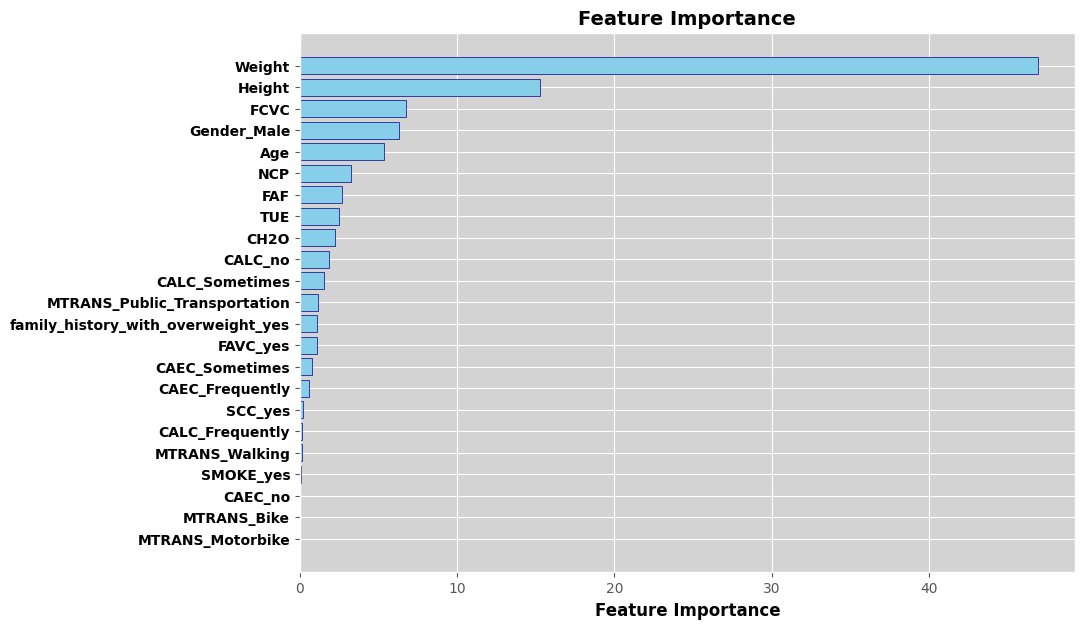

In [31]:
# Get the feature importance values and names
feature_importance = clf5.feature_importances_
feature_names = X_test_prep.columns

# Sort importances
sorted_idx = np.argsort(feature_importance)

# Create a figure
fig = plt.figure(figsize=(10, 7))

# Create horizontal bar plot
bars = plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx], align='center', color='skyblue', edgecolor='darkblue')

# Thickening the edges of horizontal bars
for bar in bars:
    bar.set_edgecolor('darkblue')

# Labels on the y-axis
plt.yticks(range(len(sorted_idx)), np.array(feature_names)[sorted_idx], fontsize=10, fontweight='bold', color='black')

# Labels and titles
plt.xlabel("Feature Importance", fontsize=12, fontweight='bold', color='black')
plt.title('Feature Importance', fontsize=14, fontweight='bold', color='black')

# Background color
plt.gca().set_facecolor('lightgrey')

plt.show()